In [3]:
# imports
import librosa
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [3]:
# feature extraction
df = pd.read_csv('ESC-50-master/meta/esc50.csv')
def extract_mfcc(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs

def extract_melspectrogram(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    return melspectrogram

for index, row in df.iterrows():
    file = 'ESC-50-master/audio/' + row['filename']
    mfccs = extract_mfcc(file)
    np.save(file.replace('.wav', '_mfcc.npy'), mfccs)
    
    melspectrogram = extract_melspectrogram(file)
    np.save(file.replace('.wav', '_melspectrogram.npy'), melspectrogram)

In [4]:
# read features
df = pd.read_csv('ESC-50-master/meta/esc50.csv')

df['mfccs'] = df['filename'].apply(lambda file: np.load('ESC-50-master/audio/' + file.replace('.wav', '_mfcc.npy')))
df['melspectrogram'] = df['filename'].apply(lambda file: np.load('ESC-50-master/audio/' +  file.replace('.wav', '_melspectrogram.npy')))

X_train, X_test, y_train, y_test = train_test_split(df[['mfccs', 'melspectrogram']], to_categorical(df['target']), test_size=0.2)

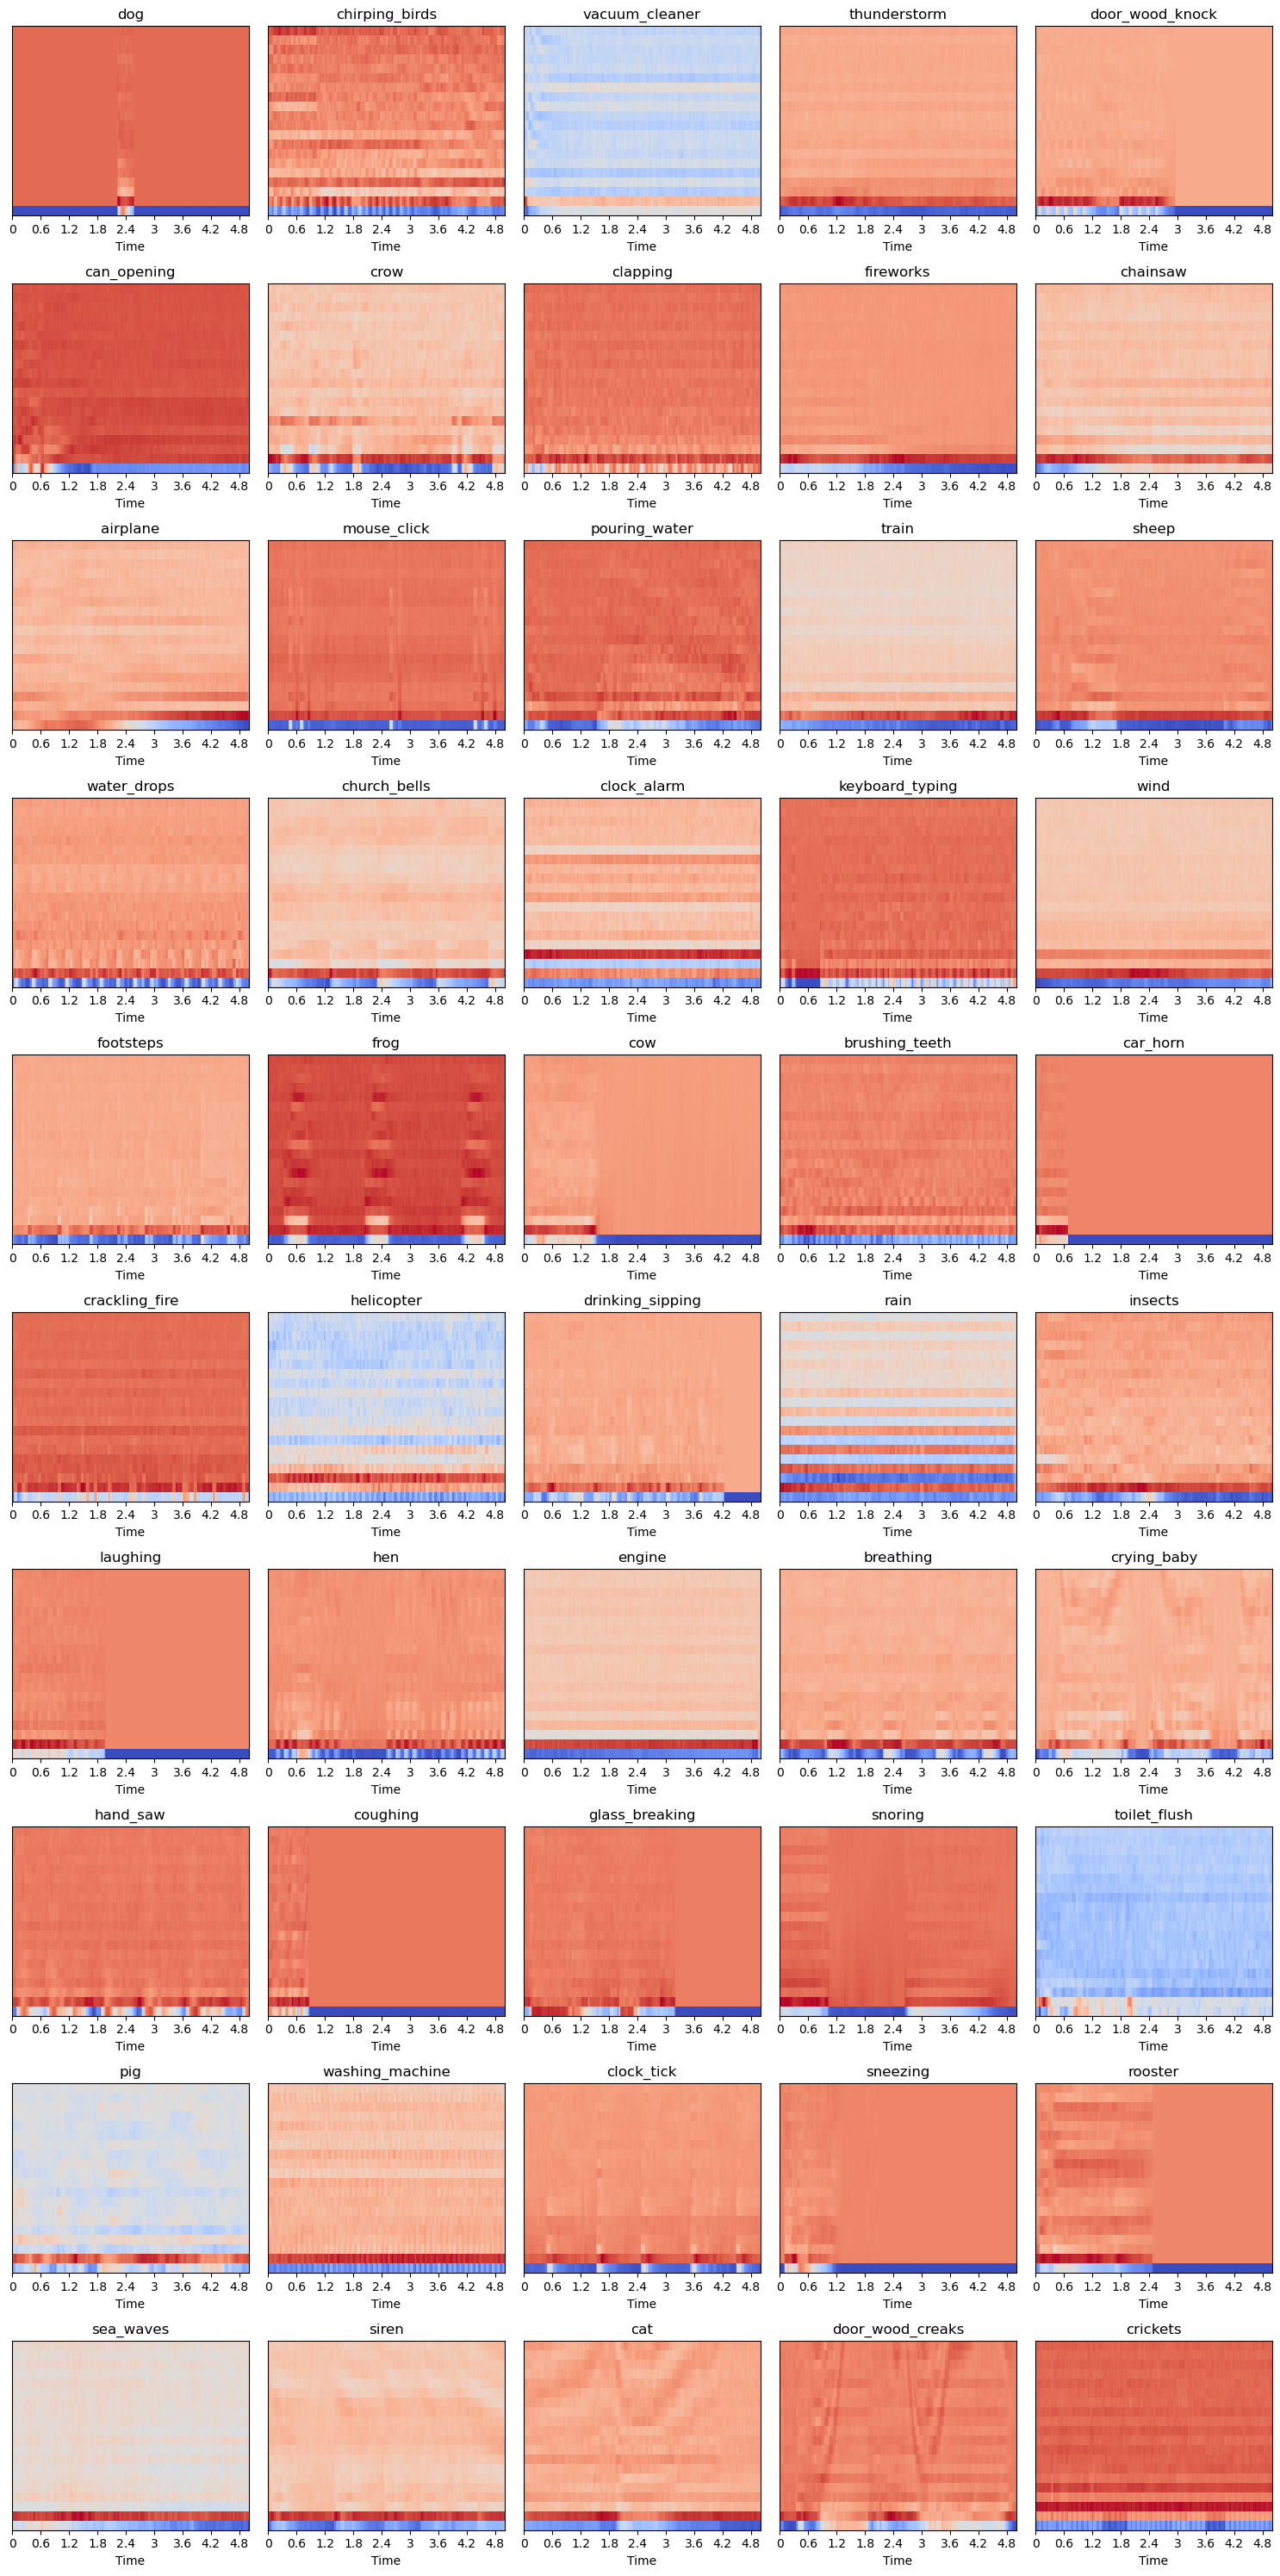

In [6]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
df = pd.read_csv('ESC-50-master/meta/esc50.csv')

unique_classes = df['category'].unique()

fig, axs = plt.subplots(10, 5, figsize=(15, 30))  # adjust this to display 50 images in a manner you find suitable
axs = axs.flatten()

for i, category in enumerate(unique_classes):
    sample_file = df[df['category'] == category].iloc[0]['filename']
    file_path = f'ESC-50-master/audio/{sample_file}'
    
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set_title(category)

plt.tight_layout()
plt.show()


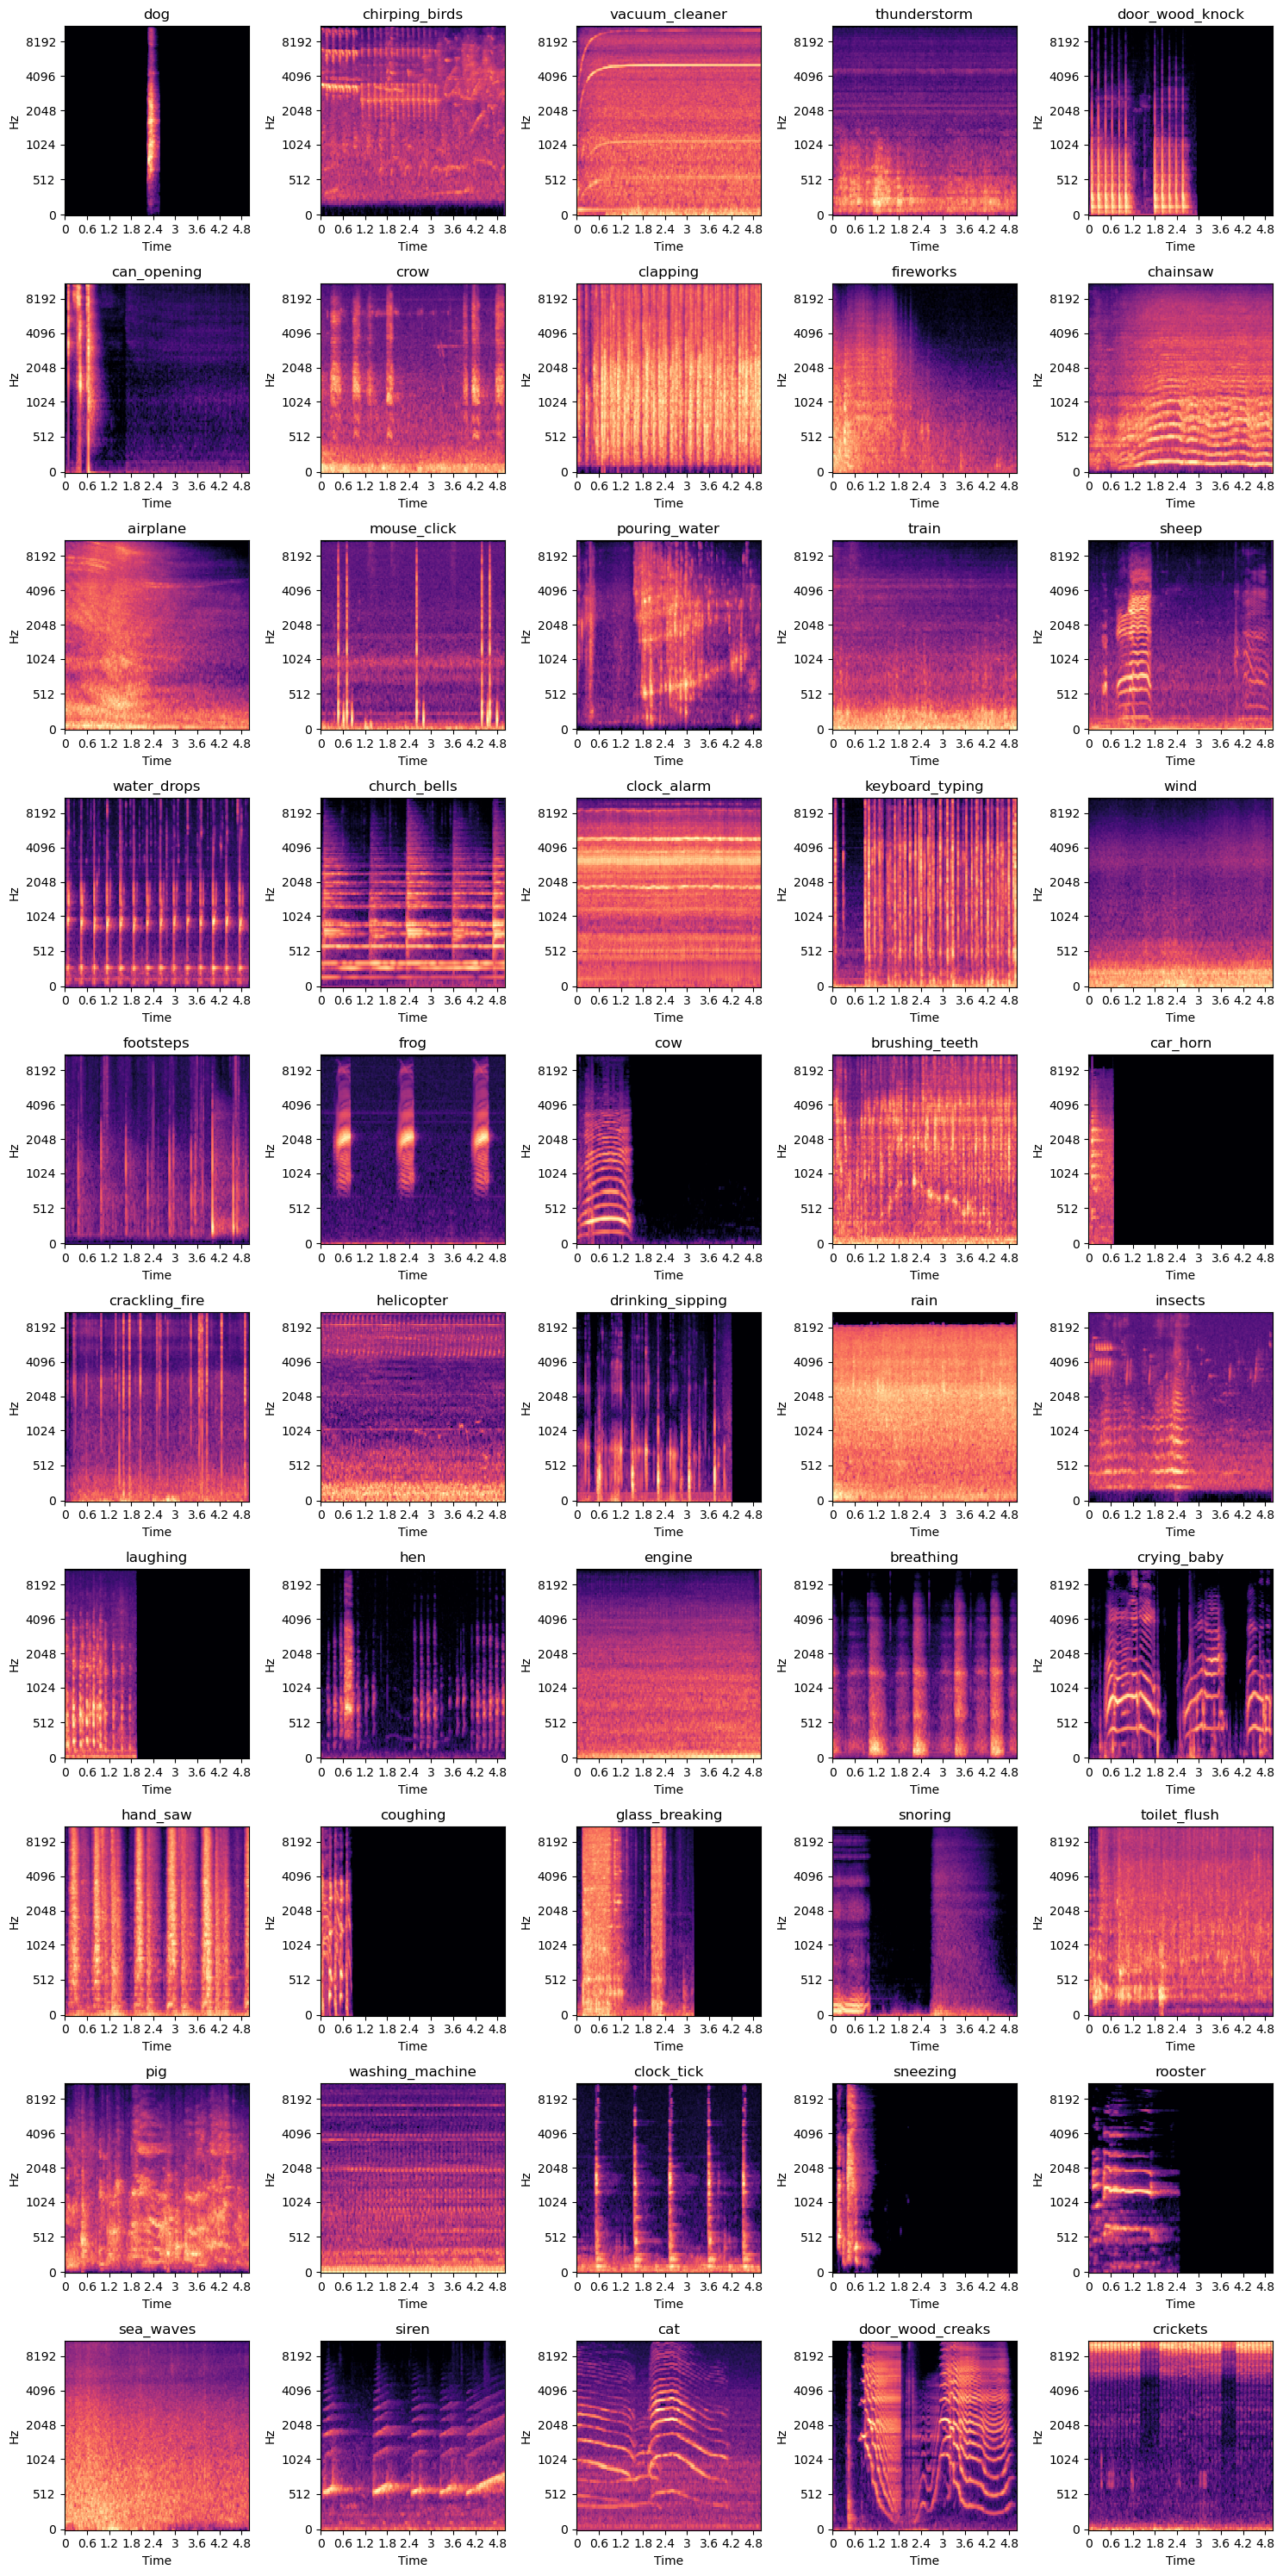

In [8]:
unique_classes = df['category'].unique()

fig, axs = plt.subplots(10, 5, figsize=(15, 30)) 
axs = axs.flatten()

for i, category in enumerate(unique_classes):
    sample_file = df[df['category'] == category].iloc[0]['filename']
    file_path = f'ESC-50-master/audio/{sample_file}'
    
    y, sr = librosa.load(file_path)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr)
    
    log_mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    librosa.display.specshow(log_mel_spect, sr=sr, x_axis='time', y_axis='mel', ax=axs[i])
    axs[i].set_title(category)

plt.tight_layout()
plt.show()


In [20]:
# mfcc
input1 = Input(shape=(X_train['mfccs'][0].shape[0], X_train['mfccs'][0].shape[1], 1))
x = Conv2D(32, (3, 3), activation='relu')(input1)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(50, activation='softmax')(x)
model1 = Model(inputs=input1, outputs=x)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(np.array([i[..., np.newaxis] for i in X_train['mfccs'].tolist()]), y_train, epochs=10, batch_size=32)

X_test_reshaped = np.array([i[..., np.newaxis] for i in X_test['mfccs'].tolist()])
y_pred = model1.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
model1.save('model1.h5')

Epoch 1/10
50/50 [==============================] - 5s 92ms/step - loss: 227.2981 - accuracy: 0.0775
Epoch 2/10
50/50 [==============================] - 5s 98ms/step - loss: 15.7936 - accuracy: 0.4281
Epoch 3/10
50/50 [==============================] - 5s 97ms/step - loss: 2.6483 - accuracy: 0.7356
Epoch 4/10
50/50 [==============================] - 5s 97ms/step - loss: 1.0383 - accuracy: 0.8662
Epoch 5/10
50/50 [==============================] - 5s 91ms/step - loss: 0.4201 - accuracy: 0.9194
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.1887 - accuracy: 0.9588
Epoch 7/10
50/50 [==============================] - 4s 84ms/step - loss: 0.2628 - accuracy: 0.9544
Epoch 8/10
50/50 [==============================] - 4s 86ms/step - loss: 0.3527 - accuracy: 0.9475
Epoch 9/10
50/50 [==============================] - 4s 88ms/step - loss: 0.3546 - accuracy: 0.9375
Epoch 10/10
13/13 [==============================] - 1s 45ms/step
              precision    recall  f1-sc

c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#mel
input2 = Input(shape=(X_train['melspectrogram'][0].shape[0], X_train['melspectrogram'][0].shape[1], 1))
x = Conv2D(32, (3, 3), activation='relu')(input2)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(50, activation='softmax')(x)
model2 = Model(inputs=input2, outputs=x)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(np.array([i[..., np.newaxis] for i in X_train['melspectrogram'].tolist()]), y_train, epochs=10, batch_size=32)

X_test_reshaped = np.array([i[..., np.newaxis] for i in X_test['melspectrogram'].tolist()])
y_pred = model2.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))
model2.save('model2.h5')

Epoch 1/10
50/50 [==============================] - 11s 213ms/step - loss: 113.0175 - accuracy: 0.1169
Epoch 2/10
50/50 [==============================] - 11s 227ms/step - loss: 9.5930 - accuracy: 0.5931
Epoch 3/10
50/50 [==============================] - 12s 238ms/step - loss: 1.1913 - accuracy: 0.8225
Epoch 4/10
50/50 [==============================] - 12s 248ms/step - loss: 0.5207 - accuracy: 0.8988
Epoch 5/10
50/50 [==============================] - 13s 258ms/step - loss: 0.3803 - accuracy: 0.9212
Epoch 6/10
50/50 [==============================] - 14s 273ms/step - loss: 0.4679 - accuracy: 0.9262
Epoch 7/10
50/50 [==============================] - 13s 264ms/step - loss: 0.4242 - accuracy: 0.9344
Epoch 8/10
50/50 [==============================] - 13s 269ms/step - loss: 0.3765 - accuracy: 0.9344
Epoch 9/10
50/50 [==============================] - 13s 269ms/step - loss: 0.2635 - accuracy: 0.9456
Epoch 10/10
13/13 [==============================] - 1s 78ms/step
              precision

In [27]:
# multi-input
input3_1 = Input(shape=(X_train['mfccs'][0].shape[0], X_train['mfccs'][0].shape[1], 1))
x1 = Conv2D(32, (3, 3), activation='relu')(input3_1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)

input3_2 = Input(shape=(X_train['melspectrogram'][0].shape[0], X_train['melspectrogram'][0].shape[1], 1))
x2 = Conv2D(32, (3, 3), activation='relu')(input3_2)
x2 = MaxPooling2D()(x2)
x2 = Flatten()(x2)

x = keras.layers.concatenate([x1, x2])
x = Dense(50, activation='softmax')(x)
model3 = Model(inputs=[input3_1, input3_2], outputs=x)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit([np.array([i[..., np.newaxis] for i in X_train['mfccs'].tolist()]), 
            np.array([i[..., np.newaxis] for i in X_train['melspectrogram'].tolist()])], 
           y_train, epochs=10, batch_size=32)


y_pred = model3.predict([np.array([i[..., np.newaxis] for i in X_test['mfccs'].tolist()]), 
                         np.array([i[..., np.newaxis] for i in X_test['melspectrogram'].tolist()])])

y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1) 
matrix = classification_report(y_true, y_pred_classes)
print("Classification report : \n", matrix)

model3.save('model3.h5')

Epoch 1/10
50/50 [==============================] - 17s 339ms/step - loss: 219.8729 - accuracy: 0.1356
Epoch 2/10
50/50 [==============================] - 17s 346ms/step - loss: 10.1658 - accuracy: 0.6219
Epoch 3/10
50/50 [==============================] - 19s 378ms/step - loss: 2.0132 - accuracy: 0.8363
Epoch 4/10
50/50 [==============================] - 20s 402ms/step - loss: 1.1742 - accuracy: 0.8975
Epoch 5/10
50/50 [==============================] - 19s 370ms/step - loss: 0.3487 - accuracy: 0.9531
Epoch 6/10
50/50 [==============================] - 19s 385ms/step - loss: 0.2101 - accuracy: 0.9731
Epoch 7/10
50/50 [==============================] - 19s 373ms/step - loss: 0.1143 - accuracy: 0.9844
Epoch 8/10
50/50 [==============================] - 18s 355ms/step - loss: 0.1404 - accuracy: 0.9812
Epoch 9/10
50/50 [==============================] - 19s 372ms/step - loss: 0.2961 - accuracy: 0.9694
Epoch 10/10
13/13 [==============================] - 2s 123ms/step
Classification report

c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
